p# Raster to Grid Interpolation

## Creat an area and a grid (Rio Primero) with rotation

In [1]:
from morpheus.project.types.discretization.spatial import Rotation, Grid
from morpheus.project.types.geometry import Polygon

area = Polygon([[(-63.70070096929353, -31.341995008370162),
                 (-63.59062809221137, -31.28770219420632),
                 (-63.55589503070645, -31.33909863389222),
                 (-63.66596790778863, -31.393361805793646),
                 (-63.70070096929353, -31.341995008370162)]])

grid = Grid.cartesian_from_polygon(
  polygon=area,
  n_cols=20,
  n_rows=20,
  rotation=Rotation(30),
)

import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(area.as_geojson()))
m.add_child(folium.GeoJson(grid.origin.as_geojson()))

n_cols = grid.n_cols()
n_rows = grid.n_rows()
cell_geometries = grid.get_cell_geometries()

for col in range(n_cols):
  for row in range(n_rows):
    if col == 0 and row == 0:
      continue
    cell_geometry = cell_geometries[row][col]
    folium.GeoJson(cell_geometry.as_geojson()).add_to(m)

m.fit_bounds(m.get_bounds())
m

## Draw a BoundingBox around the model area

In [2]:
area.bbox()

[-63.70070096929353,
 -31.393361805793646,
 -63.55589503070645,
 -31.28770219420632]

In [3]:
min_x, min_y, max_x, max_y = area.bbox()
bounding_box_polygon = Polygon([[
  (min_x, min_y),
  (min_x, max_y),
  (max_x, max_y),
  (max_x, min_y),
  (min_x, min_y)
]])
m.add_child(folium.GeoJson(bounding_box_polygon.as_geojson()))
m

## Create a raster

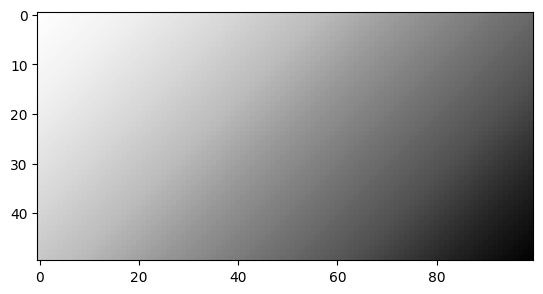

In [4]:
import numpy as np
import matplotlib.pyplot as plt

raster_x = np.linspace(min_x, max_x, 100)
raster_y = np.linspace(min_y, max_y, 50)

raster = np.zeros((len(raster_y), len(raster_x)))
for i, y in enumerate(raster_y):
  for j, x in enumerate(raster_x):
    raster[i, j] = i + j

plt.imshow(raster, origin='upper', cmap='Greys', vmin=0, vmax=150)

## Interpolate the raster to the grid and plot the result

In [5]:
from morpheus.project.infrastructure.assets.RasterInterpolationService import Raster, RasterCoordinates, RasterData, RasterInterpolationService

interpolation_service = RasterInterpolationService()

input_raster_xx, input_raster_yy = np.meshgrid(raster_x, raster_y)
input_raster_coords = RasterCoordinates(xx_coords=input_raster_xx.tolist(), yy_coords=input_raster_yy.tolist())
input_raster_data = RasterData(data=raster)
input_raster = Raster(coords=input_raster_coords, data=input_raster_data)

xx_coords, yy_coords = grid.get_wgs_coordinates()
output_coords = RasterCoordinates(xx_coords=xx_coords, yy_coords=yy_coords)
output_raster = interpolation_service.interpolate_raster(raster=input_raster, new_coords=output_coords, method='linear')

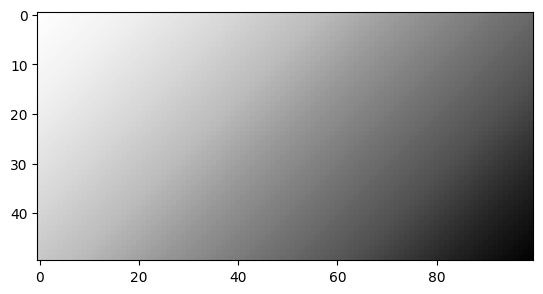

In [6]:
plt.imshow(input_raster.get_data(), origin='upper', cmap='Greys', vmin=0, vmax=150)

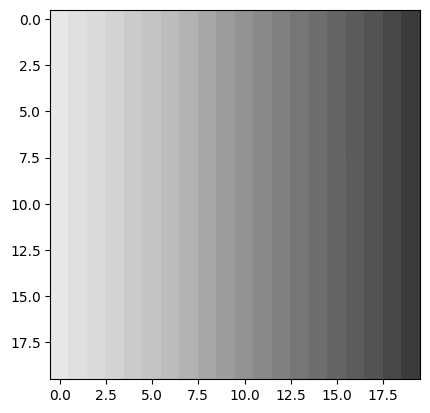

In [7]:
plt.imshow(output_raster.get_data(), origin='upper', cmap='Greys', vmin=0, vmax=150)

In [8]:
np.array(output_raster.get_data()).sum()

29597.706358006577

## Reverse the interpolation

In [9]:
re_interpolated_raster = interpolation_service.interpolate_raster(
  raster=output_raster,
  new_coords=input_raster.coords,
  method='linear'
)

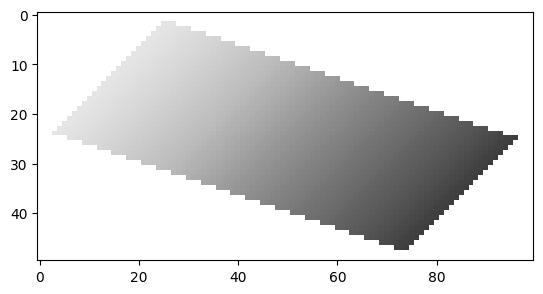

In [10]:
plt.imshow(re_interpolated_raster.get_data(), origin='upper', cmap='Greys', vmin=0, vmax=150)

In [11]:
# Replace no data values with 0
no_data_value = -9999.0
data = np.array(re_interpolated_raster.get_data())
data[data == no_data_value] = 0
data.sum()

159988.0

## Interpolate with nearest neighbor

In [12]:
output_raster_nearest = interpolation_service.interpolate_raster(
  raster=input_raster,
  new_coords=output_coords,
  method='nearest'
)

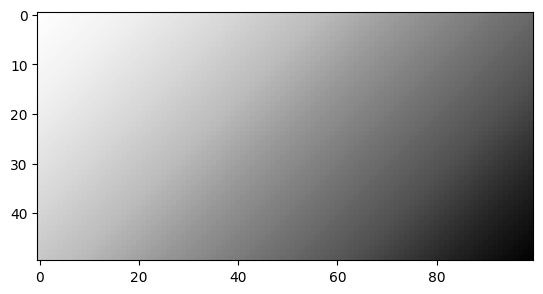

In [13]:
plt.imshow(input_raster.get_data(), origin='upper', cmap='Greys', vmin=0, vmax=150)

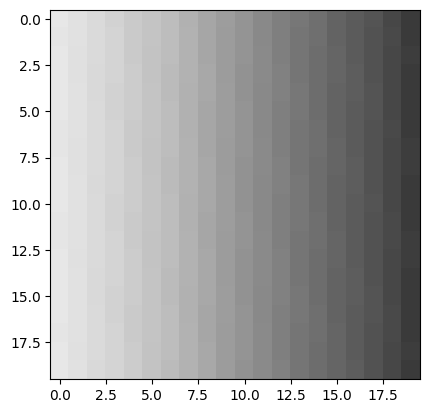

In [14]:
plt.imshow(output_raster_nearest.get_data(), origin='upper', cmap='Greys', vmin=0, vmax=150)

In [15]:
np.array(output_raster_nearest.get_data()).sum()

29599.0

In [16]:
re_interpolated_raster_nearest = interpolation_service.interpolate_raster(
  raster=output_raster_nearest,
  new_coords=input_raster.coords,
  method='nearest'
)

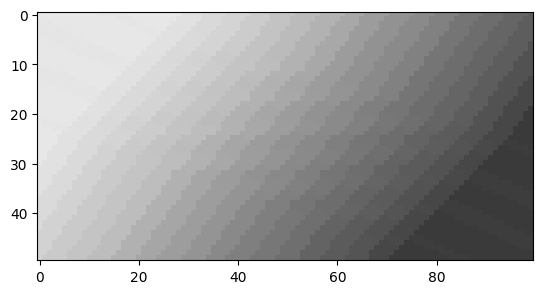

In [17]:
plt.imshow(re_interpolated_raster_nearest.get_data(), origin='upper', cmap='Greys', vmin=0, vmax=150)

In [18]:
np.array(re_interpolated_raster_nearest.get_data()).sum()

370026.0